In [1]:
# Connect to Google Drive 
# Upload the dataset to your Google drive so it can be loaded here

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


In [3]:
# import pandas lib as pd
import pandas as pd
 
# read by default 1st sheet of an excel file
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Testing FNH dataset/RandomOverSampler.xlsx', 'Sheet1')
 
print(df)
df = df.fillna(' ')
df.count()

                                                   Title   Len  \
0      Psa: ben stiller speaks out against shaken man...   132   
1      States take back hundreds of thousands of vacc...  7449   
2      On the brink: 16 hours til shutdown – cnn poll...  1357   
3      The us is getting a third coronavirus vaccine....  7855   
4      Coronavirus variant will likely drive a new wa...  3017   
...                                                  ...   ...   
14860  Cops, firefighters challenge gainesville's 'od...   446   
14861  De blasio dodges on high school admissions tes...  3177   
14862  Defense dept. issues covid "vaccination record...   255   
14863  Alaska: cheating husband emasculated after wif...   986   
14864  Woman who drinks 6 cups of coffee per day tryi...   914   

                                                 Content  \
0      Actor ben stiller urges parents with adult kid...   
1      Hundreds of thousands of covid-19 vaccine dose...   
2      a veteran of the shu

Title              14865
Len                14865
Content            14865
Source             14865
Publishing Date    14865
Label              14865
dtype: int64

In [4]:
# Normalize the dataset
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

df['Content'] = normalize(df['Content'])

In [5]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Content'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(df['Content'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

90999


# **Different Activation Functions with Split Ratio of Data = 80:20**

In [6]:
# Spliting data - withom random shuffle
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['Label'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['Label'].values[split_n:]

print("Train label","/n",train_labels)
print("/nTest label","/n",test_labels)

print(type(train_data))
print(len(train_data))
print(type(train_labels))
print(len(train_labels))

Train label /n [1 0 0 ... 1 0 1]
/nTest label /n [1 1 1 ... 1 1 1]
<class 'numpy.ndarray'>
11892
<class 'numpy.ndarray'>
11892


In [7]:
# Import tensor representations for words - GloVe Embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2023-02-21 03:02:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-21 03:02:20 ERROR 404: Not Found.

100


**Model with Activation Function = Relu**

In [38]:
# Build the architecture of the RNN model - Activation Function = Relu
     
model_relu = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20), 
    tf.keras.layers.Dense(512), 
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [42]:
model_relu.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_relu.summary()

history_relu = model_relu.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_8 (LSTM)               (None, None, 20)          6800      
                                                                 
 lstm_9 (LSTM)               (None, 20)                3280      
                                                                 
 dense_12 (Dense)            (None, 512)               10752     
                                                      

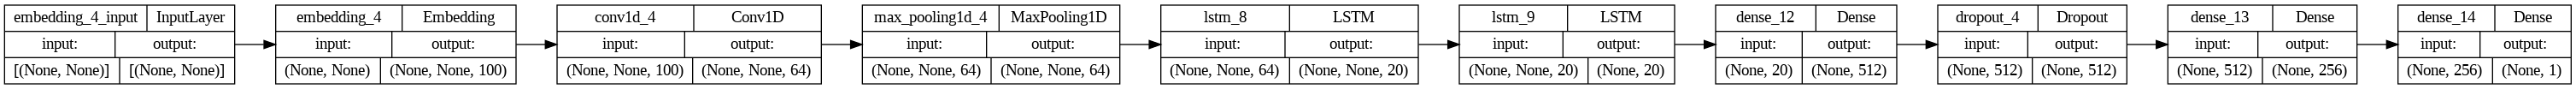

In [43]:
tf.keras.utils.plot_model(model_relu, show_shapes=True, rankdir="LR")

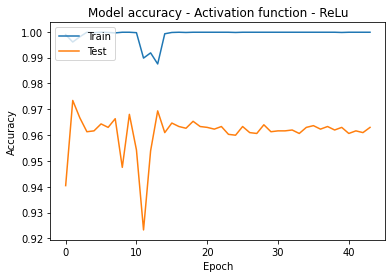

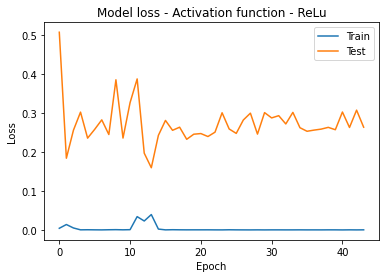

In [44]:
# Visualize the results:

plt.plot(history_relu.history['accuracy'])
plt.plot(history_relu.history['val_accuracy'])
plt.title('Model accuracy - Activation function - ReLu')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_relu.history['loss'])
plt.plot(history_relu.history['val_loss'])
plt.title('Model loss - Activation function - ReLu')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [45]:
pred_relu = model_relu.predict(test_data)

binary_predictions_relu = []

for i in pred_relu:
    if i >= 0.5:
        binary_predictions_relu.append(1)
    else:
        binary_predictions_relu.append(0) 

93/93 [==============================] - 2s 9ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

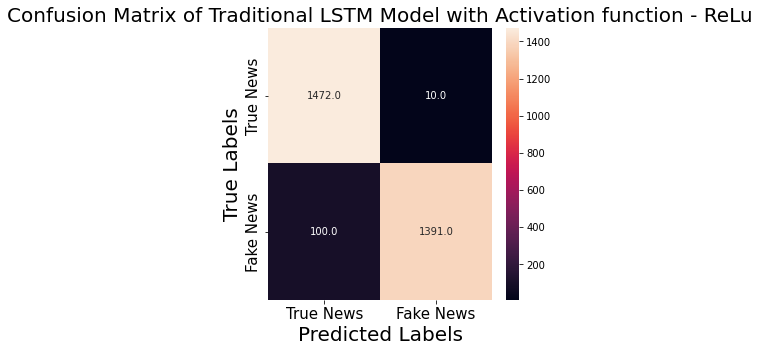

In [47]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_relu, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix of Traditional LSTM Model with Activation function - ReLu', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15) 

In [48]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_relu = metrics.accuracy_score(test_labels, binary_predictions_relu)
Precision_relu = metrics.precision_score(test_labels, binary_predictions_relu)
Sensitivity_recall_relu = metrics.recall_score(test_labels, binary_predictions_relu)
Specificity_relu = metrics.recall_score(test_labels, binary_predictions_relu, pos_label=0)
F1_score_relu = metrics.f1_score(test_labels, binary_predictions_relu)

print("Accuracy of LSTM Model - Activation function - ReLu =", Accuracy_relu)
print("Precision of LSTM Model - Activation function - ReLu =", Precision_relu)
print("Sensitivity_recall of LSTM Model - Activation function - ReLu =", Sensitivity_recall_relu)
print("Specificity of LSTM Model - Activation function - ReLu =", Specificity_relu)
print("F1_score of LSTM Model - Activation function - ReLu =", F1_score_relu)


Accuracy of LSTM Model - Activation function - ReLu = 0.9630003363605786
Precision of LSTM Model - Activation function - ReLu = 0.9329309188464118
Sensitivity_recall of LSTM Model - Activation function - ReLu = 0.9928622412562456
Specificity of LSTM Model - Activation function - ReLu = 0.9363867684478372
F1_score of LSTM Model - Activation function - ReLu = 0.9619640387275241


**Model with Activation function = tanh**

In [49]:
# Build the architecture of the RNN model - Activation Function = tanh
     
model_tanh = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [50]:
model_tanh.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_tanh.summary()

history_tanh = model_tanh.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_5 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 20)          6800      
                                                                 
 lstm_11 (LSTM)              (None, 20)                3280      
                                                                 
 dense_15 (Dense)            (None, 512)               10752     
                                                      

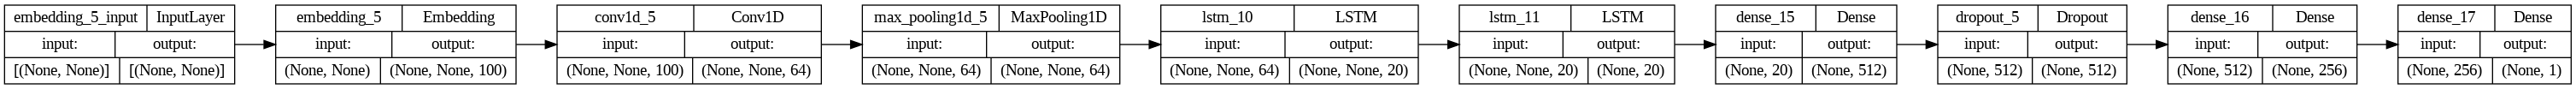

In [51]:
tf.keras.utils.plot_model(model_tanh, show_shapes=True, rankdir="LR")

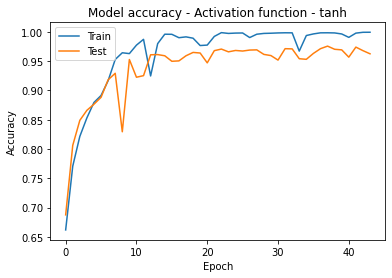

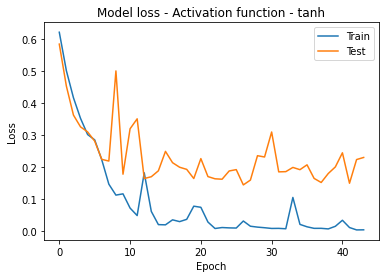

In [53]:
# Visualize the results:

plt.plot(history_tanh.history['accuracy'])
plt.plot(history_tanh.history['val_accuracy'])
plt.title('Model accuracy - Activation function - tanh')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_tanh.history['loss'])
plt.plot(history_tanh.history['val_loss'])
plt.title('Model loss - Activation function - tanh')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [54]:
pred_tanh = model_tanh.predict(test_data)

binary_predictions_tanh = []

for i in pred_tanh:
    if i >= 0.5:
        binary_predictions_tanh.append(1)
    else:
        binary_predictions_tanh.append(0) 

93/93 [==============================] - 1s 6ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

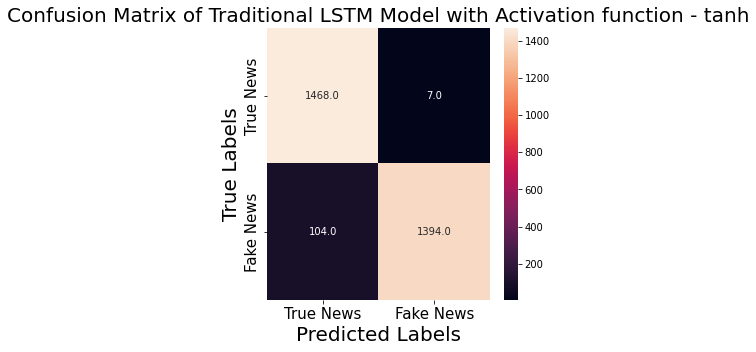

In [55]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_tanh, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix of Traditional LSTM Model with Activation function - tanh', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [56]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_tanh = metrics.accuracy_score(test_labels, binary_predictions_tanh)
Precision_tanh = metrics.precision_score(test_labels, binary_predictions_tanh)
Sensitivity_recall_tanh = metrics.recall_score(test_labels, binary_predictions_tanh)
Specificity_tanh = metrics.recall_score(test_labels, binary_predictions_tanh, pos_label=0)
F1_score_tanh = metrics.f1_score(test_labels, binary_predictions_tanh)

print("Accuracy of LSTM Model - Activation function - tanh =", Accuracy_tanh)
print("Precision of LSTM Model - Activation function - tanh =", Precision_tanh)
print("Sensitivity_recall of LSTM Model - Activation function - tanh =", Sensitivity_recall_tanh)
print("Specificity of Model - Activation function - tanh =", Specificity_tanh)
print("F1_score of LSTM Model - Activation function - tanh =", F1_score_tanh)

Accuracy of LSTM Model - Activation function - tanh = 0.9626639757820383
Precision of LSTM Model - Activation function - tanh = 0.9305740987983978
Sensitivity_recall of LSTM Model - Activation function - tanh = 0.9950035688793719
Specificity of Model - Activation function - tanh = 0.9338422391857506
F1_score of LSTM Model - Activation function - tanh = 0.9617109348051052


**Model with Activation function = Sigmoid**

In [57]:
# Build the architecture of the RNN model - Activation Function = sigmoid
     
model_sigmoid = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='sigmoid'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [59]:
model_sigmoid.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_sigmoid.summary()

history_sigmoid = model_sigmoid.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_6 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, None, 20)          6800      
                                                                 
 lstm_13 (LSTM)              (None, 20)                3280      
                                                                 
 dense_18 (Dense)            (None, 512)               10752     
                                                      

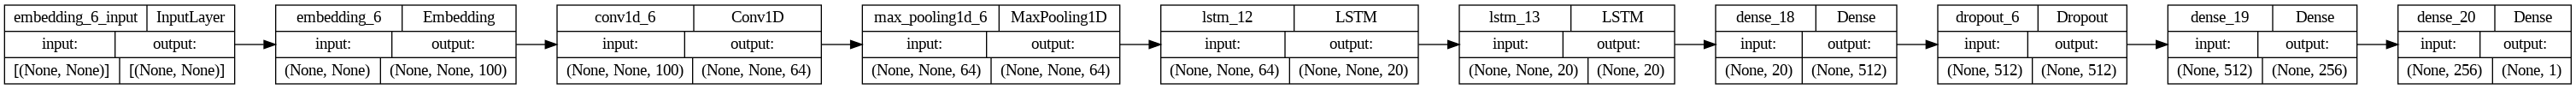

In [60]:
tf.keras.utils.plot_model(model_sigmoid, show_shapes=True, rankdir="LR")

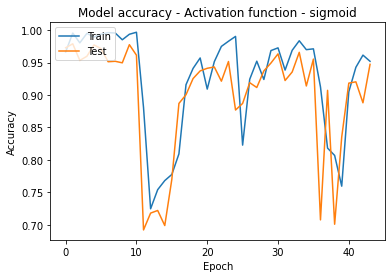

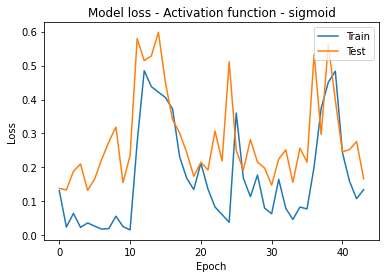

In [61]:
# Visualize the results:

plt.plot(history_sigmoid.history['accuracy'])
plt.plot(history_sigmoid.history['val_accuracy'])
plt.title('Model accuracy - Activation function - sigmoid')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_sigmoid.history['loss'])
plt.plot(history_sigmoid.history['val_loss'])
plt.title('Model loss - Activation function - sigmoid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [62]:
pred_sigmoid = model_sigmoid.predict(test_data)

binary_predictions_sigmoid = []

for i in pred_sigmoid:
    if i >= 0.5:
        binary_predictions_sigmoid.append(1)
    else:
        binary_predictions_sigmoid.append(0) 

93/93 [==============================] - 1s 6ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

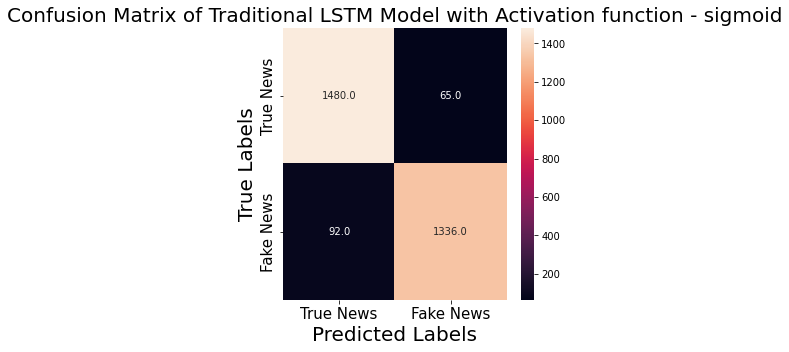

In [63]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_sigmoid, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix of Traditional LSTM Model with Activation function - sigmoid', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [64]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_sigmoid = metrics.accuracy_score(test_labels, binary_predictions_sigmoid)
Precision_sigmoid = metrics.precision_score(test_labels, binary_predictions_sigmoid)
Sensitivity_recall_sigmoid = metrics.recall_score(test_labels, binary_predictions_sigmoid)
Specificity_sigmoid = metrics.recall_score(test_labels, binary_predictions_sigmoid, pos_label=0)
F1_score_sigmoid = metrics.f1_score(test_labels, binary_predictions_sigmoid)

print("Accuracy of LSTM Model - Activation function - sigmoid =", Accuracy_sigmoid)
print("Precision of LSTM Model - Activation function - sigmoid =", Precision_sigmoid)
print("Sensitivity_recall of LSTM Model - Activation function - sigmoid) =", Sensitivity_recall_sigmoid)
print("Specificity of LSTM Model - Activation function - sigmoid =", Specificity_sigmoid)
print("F1_score of LSTM Model - Activation function - sigmoid =", F1_score_sigmoid)

Accuracy of LSTM Model - Activation function - sigmoid = 0.9471913891691893
Precision of LSTM Model - Activation function - sigmoid = 0.9355742296918768
Sensitivity_recall of LSTM Model - Activation function - sigmoid) = 0.953604568165596
Specificity of LSTM Model - Activation function - sigmoid = 0.9414758269720102
F1_score of LSTM Model - Activation function - sigmoid = 0.944503358077059


**Model with Activation function = Softmax**

In [70]:
# Build the architecture of the RNN model - Activation Function = softmax
     
model_softmax = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='sigmoid'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [71]:
model_softmax.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_softmax.summary()

history_softmax = model_softmax.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_8 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_16 (LSTM)              (None, None, 20)          6800      
                                                                 
 lstm_17 (LSTM)              (None, 20)                3280      
                                                                 
 dense_24 (Dense)            (None, 512)               10752     
                                                      

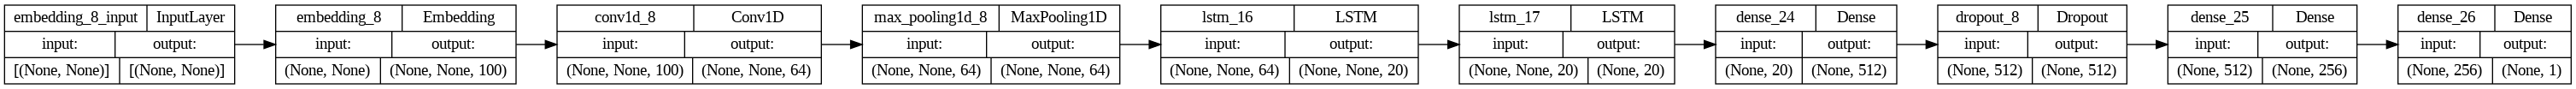

In [72]:
tf.keras.utils.plot_model(model_softmax, show_shapes=True, rankdir="LR")

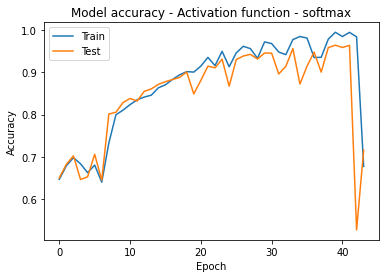

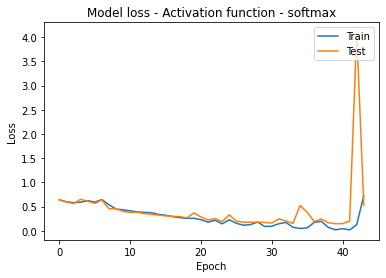

In [73]:
# Visualize the results:

plt.plot(history_softmax.history['accuracy'])
plt.plot(history_softmax.history['val_accuracy'])
plt.title('Model accuracy - Activation function - softmax')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_softmax.history['loss'])
plt.plot(history_softmax.history['val_loss'])
plt.title('Model loss - Activation function - softmax')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [74]:
pred_softmax = model_softmax.predict(test_data)

binary_predictions_softmax = []

for i in pred_softmax:
    if i >= 0.5:
        binary_predictions_softmax.append(1)
    else:
        binary_predictions_softmax.append(0) 

93/93 [==============================] - 2s 7ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

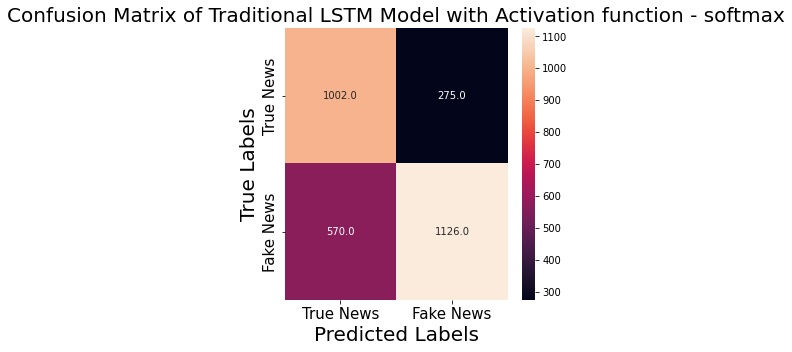

In [75]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_softmax, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix of Traditional LSTM Model with Activation function - softmax', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [76]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_softmax = metrics.accuracy_score(test_labels, binary_predictions_softmax)
Precision_softmax = metrics.precision_score(test_labels, binary_predictions_softmax)
Sensitivity_recall_softmax = metrics.recall_score(test_labels, binary_predictions_softmax)
Specificity_softmax = metrics.recall_score(test_labels, binary_predictions_softmax, pos_label=0)
F1_score_softmax = metrics.f1_score(test_labels, binary_predictions_softmax)

print("Accuracy of LSTM Model - Activation function - softmax =", Accuracy_softmax)
print("Precision of LSTM Model - Activation function - softmax =", Precision_softmax)
print("Sensitivity_recall of LSTM Model - Activation function - softmax) =", Sensitivity_recall_softmax)
print("Specificity of LSTM Model - Activation function - softmax =", Specificity_softmax)
print("F1_score of LSTM Model - Activation function - softmax =", F1_score_softmax)

Accuracy of LSTM Model - Activation function - softmax = 0.7157753111335351
Precision of LSTM Model - Activation function - softmax = 0.6639150943396226
Sensitivity_recall of LSTM Model - Activation function - softmax) = 0.8037116345467523
Specificity of LSTM Model - Activation function - softmax = 0.6374045801526718
F1_score of LSTM Model - Activation function - softmax = 0.7271553115918631


**Combination of All the Results**

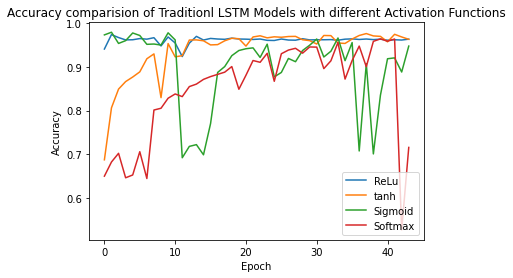

In [80]:
plt.plot(history_relu.history['val_accuracy'])
plt.plot(history_tanh.history['val_accuracy'])
plt.plot(history_sigmoid.history['val_accuracy'])
plt.plot(history_softmax.history['val_accuracy'])
plt.title('Accuracy comparision of Traditionl LSTM Models with different Activation Functions')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ReLu', 'tanh', 'Sigmoid', 'Softmax'], loc='lower right')
plt.show()

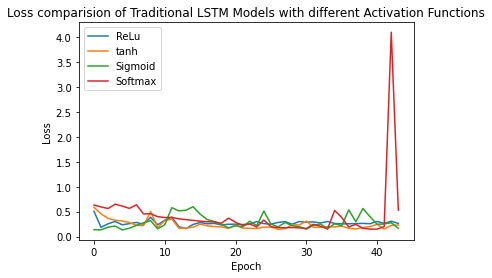

In [81]:
plt.plot(history_relu.history['val_loss'])
plt.plot(history_tanh.history['val_loss'])
plt.plot(history_sigmoid.history['val_loss'])
plt.plot(history_softmax.history['val_loss'])
plt.title('Loss comparision of Traditional LSTM Models with different Activation Functions')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ReLu', 'tanh', 'Sigmoid', 'Softmax'], loc='upper left')
plt.show()